In [0]:
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 491kB 24.7MB/s 
     |████████████████████████████████| 215kB 50.7MB/s 
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 4.5.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>=3.6, but you'll have coverage 4.5.3 which is incompatible.
  Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
Populating the interactive namespace from numpy and matplotlib


In [0]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [0]:

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Normalize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Load data

In [0]:
path="/content/gdrive/My Drive/data/"
train_data = np.load(path+"kmnist-train-imgs.npy")
test_data = np.load(path+"kmnist-test-imgs.npy")
train_labels = np.load(path+"kmnist-train-labels.npy")
classmap = pd.read_csv(path+"kmnist_classmap.csv")

In [0]:
classmap

,index,codepoint,char
0,0,U+304A,お
1,1,U+304D,き
2,2,U+3059,す
3,3,U+3064,つ
4,4,U+306A,な
5,5,U+306F,は
6,6,U+307E,ま
7,7,U+3084,や
8,8,U+308C,れ
9,9,U+3092,を


In [0]:
print(train_data.shape)

(60000, 28, 28)


## Calculate mean and std

In [0]:
mean_train = train_data.mean(axis=(0,1,2))/255
std_train = train_data.std(axis=(0,1,2))/255
#mean_test = test_data.mean(axis=(0,1,2))/255
#std_test = test_data.std(axis=(0,1,2))/255

In [0]:
print('train mean', mean_train )
print('train std', std_train )
#print('test mean', mean_test )
#print('test std', std_test )

train mean 0.19176214735894356
train std 0.3483428303463684


In [0]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_train, std=std_train),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_test, std=std_test),
])

In [0]:
type(train_data)
type(train_labels)

numpy.ndarray

### Split

In [0]:
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(train_data, train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

In [0]:
X_train, y_train = torch.from_numpy(train_data)[indices[0]], torch.from_numpy(np.array(train_labels)[indices[0]])
X_val, y_val = torch.from_numpy(train_data)[indices[1]], torch.from_numpy(np.array(train_labels)[indices[1]])
X_test, y_test = torch.from_numpy(test_data), torch.from_numpy(test_data)

In [0]:
def Normlization(X, mean_train, std_train):
    X /= 255. 
    #mean = X.numpy().mean(axis=(0,1,2))
    #std = X.numpy().std(axis=(0,1,2))
    X -= mean_train
    X /= std_train
    return X

In [0]:
X_train = Normlization(X_train.float(),mean_train, std_train)
X_val = Normlization(X_val.float(),mean_train, std_train)
X_test = Normlization(X_test.float(),mean_train, std_train)

In [0]:
# Check if 0-mean and 1-std after normlization
print("train mean after normlization:", X_train.numpy().mean(axis=(0,1,2)))
print("train std after normlization:", X_train.numpy().std(axis=(0,1,2)))
print(" ")

"""
print("val mean after normlization:", X_val.numpy().mean(axis=(0,1,2)))
print("val std after normlization:", X_val.numpy().std(axis=(0,1,2)))
print(" ")
print("test mean after normlization:", X_test.numpy().mean(axis=(0,1,2)))
print("test std after normlization:", X_test.numpy().std(axis=(0,1,2)))
"""

train mean after normlization: -5.7031863e-05
train std after normlization: 0.9999163
 


'\nprint("val mean after normlization:", X_val.numpy().mean(axis=(0,1,2)))\nprint("val std after normlization:", X_val.numpy().std(axis=(0,1,2)))\nprint(" ")\nprint("test mean after normlization:", X_test.numpy().mean(axis=(0,1,2)))\nprint("test std after normlization:", X_test.numpy().std(axis=(0,1,2)))\n'

## Model

In [0]:
from collections import OrderedDict

class LeNet5(nn.Module):
    """
    Input - 3x32x32
    -----Convolution Layers--------
    C1 - 6@28x28 (5x5 kernel)
    S2 - 6@14x14 (2x2 kernel, stride 2) Pool layer Subsampling
    C3 - 16@10x10 (5x5 kernel)
    S4 - 16@5x5 (2x2 kernel, stride 2) Pool layer Subsampling
    -----Full Connected Layers-------
    C5 - 1024@1x1 (5x5 kernel)
    F6 - 84
    F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=5, padding = 2, stride=1)),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('relu2', nn.ReLU()),
            ('c3', nn.Conv2d(6, 16, kernel_size=5)),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('relu4', nn.ReLU())
             ]))

        self.fc = nn.Sequential(OrderedDict([
            ('c5', nn.Linear(16*5*5, 120)),
            ('relu5', nn.ReLU()),
            ('dp1',nn.Dropout(0.5)),
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('dp2',nn.Dropout(0.5)),
            ('f7', nn.Linear(84, 10))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(-1, output.size(1)*output.size(2))
        output = self.fc(output)
        return output
  
x = torch.randn((1, 1, 32, 32))
model = LeNet5()
y = model(x)
print(y)

RuntimeError: ignored

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 1150)
    self.f6 = nn.Linear(1150, 256)
    self.output = nn.Linear(256, 10)
    self.act = nn.ReLU()
    self.dp = nn.Dropout(0.5)
    
  def forward(self, x):
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.dp(x)
    x = self.act(self.f6(x))
    x = self.dp(x)
    return self.output(x)
  
x = torch.randn((1, 1, 28, 28))
model = LeNet5()
y = model(x)
print(y)

tensor([[-0.0564,  0.1724,  0.0007, -0.1374,  0.0382, -0.0738,  0.0631, -0.0840,
          0.0305, -0.0632]], grad_fn=<AddmmBackward>)


In [0]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 5
weights_set = [0.0, 1e-3, 1e-4, 1e-5]

In [0]:
km_train = TensorDataset(X_train, y_train.long())
km_validate = TensorDataset(X_val, y_val.long())
#cifar_test = TensorDataset(X_test, y_test.long())

In [0]:
def train(model, optimizer, criterion, data_loader, plot=True):
    """Train function, the plot arguement is used to decide whether plot or not """
    model.train()
    train_loss, train_accuracy = 0, 0
    iii = 0
    
    if plot:
      fig, axarr = plt.subplots(1, 5, figsize=(10, 2))
      axarr = axarr.flatten()
    
    for X, y in data_loader:
        if plot:
           
            # Show 5 input images to do the sanity check
            while iii < 5:
                print(X.shape)
                X_show = X[iii]
                axarr[iii].imshow(X_show)
                #axarr[iii].set_title(classes[y[iii]])
                iii += 1
      
        X = X.view(-1, 1, 28, 28)
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 28, 28))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)
  
def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 32, 32))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

In [0]:
def train_model(weight_decay=0):
  """The train function which takes the weight-decay as the argument """
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay )
  criterion = nn.CrossEntropyLoss()
  
  train_loader = DataLoader(km_train, batch_size=batch_size, shuffle=True, num_workers=4)
  validation_loader = DataLoader(km_validate, batch_size=test_batch_size, shuffle=False, num_workers=4)
  #test_loader = DataLoader(cifar_test, batch_size=test_batch_size, shuffle=False, num_workers=4)
  
  liveloss = PlotLosses()
  for epoch in range(n_epochs):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()
      liveloss.update(logs)
      liveloss.draw()
      """
      print(validation_loss.item())
      print(validation_loss)
      print(type(validation_loss.item()))
      print(type(validation_loss))
      """

  #test_loss, test_accuracy = validate(model, criterion, test_loader)    
  #print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
  print("")
      
  return model

In [0]:
def evaluate_output(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0)

In [0]:
def train_validation(train_set, validation_set, model, optimizer ,criterion, plot=True):
  """The train function which takes the weight-decay as the argument """
  set_seed(seed)
  model = model
  optimizer = optimizer
  criterion = criterion
  
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
  validation_loader = DataLoader(validation_set, batch_size=test_batch_size, shuffle=False, num_workers=4)
  #test_loader = DataLoader(cifar_test, batch_size=test_batch_size, shuffle=False, num_workers=4)
  if plot:
      liveloss = PlotLosses()
  for epoch in range(n_epochs):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
      
      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()
      if plot:
          liveloss.update(logs)
          liveloss.draw()
  
  result = [validation_loss.item(), validation_accuracy.item(), train_loss.item(), train_accuracy.item()]
  return result

In [0]:
def cross_validation(model, optimizer ,criterion, seed=seed, n=3):
        #shuffler = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42).split(train_data, train_labels)
        X = train_data
        y = train_labels
        X_train_set = []
        y_train_set = []
        X_val_set = []
        y_val_set = []
        result = []
        
        # K-fold split
        skf = StratifiedKFold(n_splits=n, random_state=seed, shuffle=False)
        skf.get_n_splits(X, y)
        for train_index, test_index in skf.split(X, y):
            print("TRAIN:", train_index, "TEST:", test_index)
            X_train_set.append(torch.from_numpy(X[train_index])) 
            X_val_set.append(torch.from_numpy(X[test_index]))
            y_train_set.append(torch.from_numpy(y[train_index]))
            y_val_set.append(torch.from_numpy(y[test_index]))

        for i, data in enumerate(X_train_set):
            mean = data.numpy().mean(axis=(0,1,2))/255
            std = data.numpy().std(axis=(0,1,2))/255
            print(mean," " ,std)
            X_train_set[i] = Normlization(X_train_set[i].float(), mean, std)
            X_val_set[i] = Normlization(X_val_set[i].float(), mean, std)

            # Check 0-mean, 1-std
            print("The ", i," train set, mean after normlization: ", X_train_set[i].numpy().mean(axis=(0,1,2)))
            print("The ", i," train set, std after normlization: ", X_train_set[i].numpy().std(axis=(0,1,2)))
        
        for i in range(n):
            train_set = TensorDataset(X_train_set[i], y_train_set[i].long())
            validation_set = TensorDataset(X_val_set[i], y_val_set[i].long())
            result.append(train_validation(train_set, validation_set, model, optimizer ,criterion))
            print("The ", i, " fold finished.")
        ave_result = np.array(result).mean(axis=0)
        
        print(" ")
        print("Result:")
        print("----------------------------")
        print("Average validation loss for ", n ," folds is ", ave_result[0])
        print("Average validation accuracy for ", n ," folds is ", ave_result[1])
        print("Average train loss for ", n ," folds is ", ave_result[2])
        print("Average train accuracy for ", n ," folds is ", ave_result[3])
        return ave_result

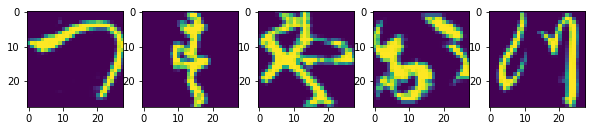

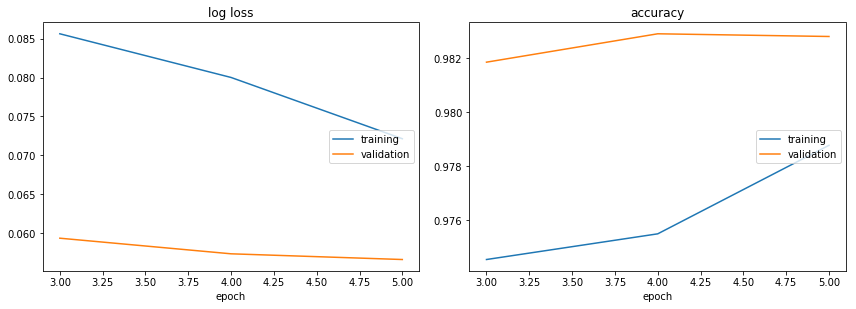

log loss:
training   (min:    0.072, max:    0.108, cur:    0.072)
validation (min:    0.057, max:    0.060, cur:    0.057)

accuracy:
training   (min:    0.967, max:    0.979, cur:    0.979)
validation (min:    0.981, max:    0.983, cur:    0.983)
The  2  fold finished.
The average validation loss for  3  folds is  0.0947685477634271
The average validation accuracy for  3  folds is  0.9708833333333334
The average train loss for  3  folds is  0.13289971401294073
The average train accuracy for  3  folds is  0.9585500000000001


In [0]:
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=0 )
criterion = nn.CrossEntropyLoss()
res = cross_validation(model, optimizer, criterion)

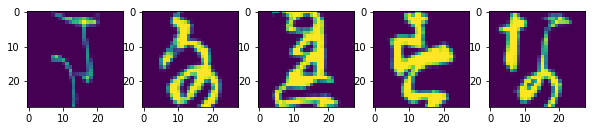

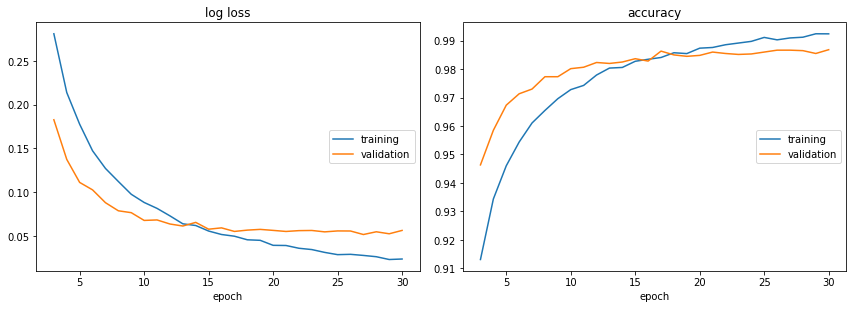

log loss:
training   (min:    0.023, max:    1.046, cur:    0.024)
validation (min:    0.052, max:    0.407, cur:    0.056)

accuracy:
training   (min:    0.655, max:    0.992, cur:    0.992)
validation (min:    0.870, max:    0.987, cur:    0.987)



In [0]:
model = train_model()

In [0]:
print(test_data.shape)
km_test = TensorDataset(X_test, y_test.long())
test_loader = DataLoader(km_test, batch_size=test_batch_size, shuffle=False, num_workers=2)
y_pred = evaluate_output(model, test_loader)

(10000, 28, 28)


In [0]:
len(y_pred)
order_set = [x for x in range(len(y_pred))]
print(np.array(order_set))

[   0    1    2 ... 9997 9998 9999]


In [0]:
np.savetxt('submission.csv',  np.c_[np.array(order_set).astype(int), y_pred.astype(int)],delimiter=",", fmt = "%i") 

In [0]:
model = train_model()

KeyboardInterrupt: ignored